In [1]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [2]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [3]:
hdf_dir = Path("../data")

In [4]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [5]:
fname = "2021_4_8.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<80} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1617900790 scan R0 F1 (R0 F1 DET, P2 F1 RC, J12 J23)                             : 641
1  <> 1617901451 scan P2 F1 (R0 F1 DET, P2 F1 RC, J12 J23)                             : 641
2  <> 1617902364 scan P2 F1 ratio (R0 F1 DET, P2 F1 RC, J12 J23)                       : 1701
3  <> 1617902910 scan P2 F1 ratio (R0 F1 DET, P2 F1 RC, J12 J23)                       : 8001
4  <> 1617908053 scan P2 F1 ratio with phase modulation (R0 F1 DET, P2 F1 RC, J12 J23) : 4921
5  <> 1617909582 scan P2 F1 ratio with phase modulation (R0 F1 DET, P2 F1 RC, J12 J23) : 10201
6  <> 1617911679 scan P2 F1 ratio no phase modulation (R0 F1 DET, P2 F1 RC, J12 J23)   : 201
7  <> 1617911749 scan P2 F1 ratio no phase modulation (R0 F1 DET, P2 F1 RC, J12 J23)   : 10201
8  <> 1617913825 scan P2 F1 ratio phase modulation (R0 F1 DET, P2 F1 RC, J12 J23)      : 10201
9  <> 1617916212 scan R0 F1 (R0 F1 DET, P2 F1 RC, J12 J23)                             : 106
10 <> 1617916297 scan R0 F1 (R0 F1 DET, P2 F1 RC, J12 J23)   

### RC EOM off for all subsequent measurements unless stated otherwise
## Scan R0 F1

In [6]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [7]:
dnames = [dset_names[0]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

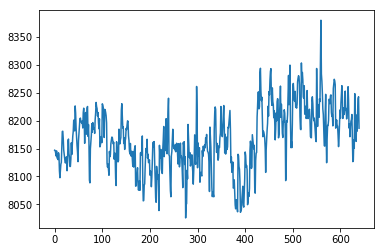

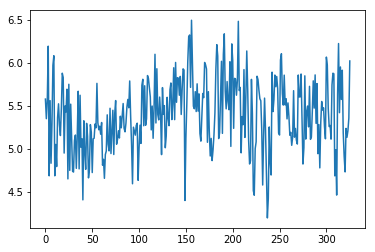

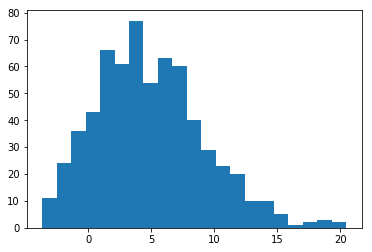

In [8]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [9]:
yag_cutoff = 250
ptn_cutoff = 7000
abs_cutoff = 3
fl_cutoff = -5000

In [10]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

48.9% data discarded


In [11]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

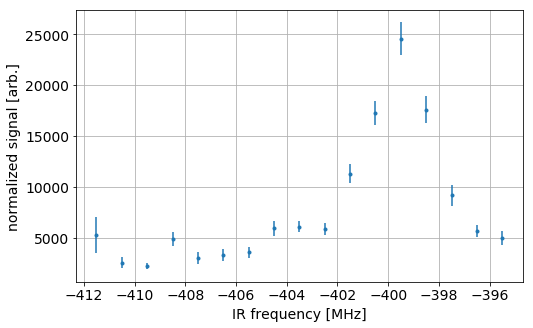

In [12]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

### Detection laser beam is passed through the detection region twice, and then retroflected (going through a $\lambda/4$) for another two passes. Laser is elliptically expanded in height.

### All with phase modulation on detection

## Scan R0 F2 F1'=3/2
17 mW

In [6]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [7]:
dset_idx = 0
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

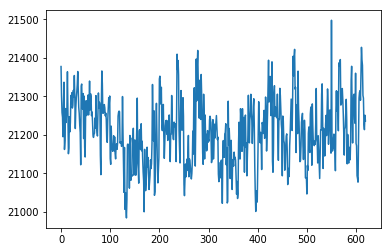

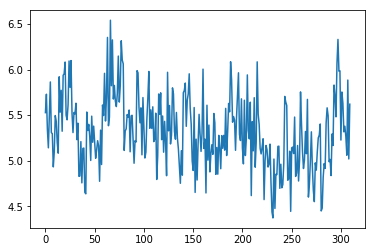

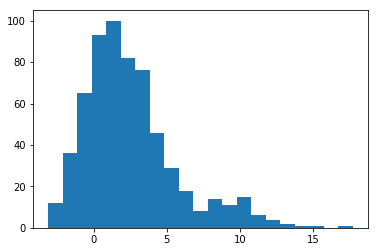

In [8]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [9]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 6
fl_cutoff = -1e6

In [10]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

87.3% data discarded


In [11]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\CeNTREX\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


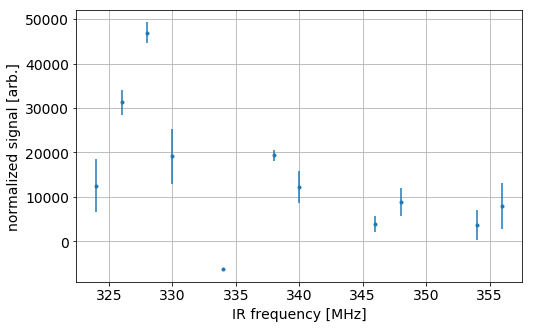

In [13]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [14]:
m = (~np.isnan(err))
bin_means = bin_means[m]
stat = stat[m]
err = err[m]

5.145453837131369
<Parameter 'center', value=330.3676153134835 +/- 1.05, bounds=[-inf:inf]>
<Parameter 'fwhm', value=12.708050557389253 +/- 2.15, bounds=[-inf:inf], expr='1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'>
<Parameter 'c', value=2043.1473322172105 +/- 4.1e+03, bounds=[-inf:inf]>


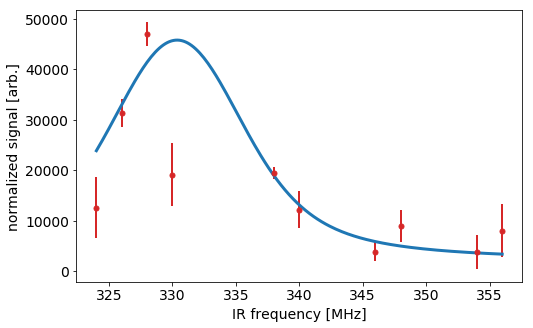

In [15]:
import lmfit
model = lmfit.models.VoigtModel() + lmfit.models.ConstantModel()
params = lmfit.models.VoigtModel().guess(stat, bin_means)
params.add('c', 0)
result = model.fit(stat, params = params, x = bin_means, weights = 1/err)

x = np.linspace(bin_means.min(), bin_means.max(), 201)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, model.eval(x=x, params = result.params), lw = 3)
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', color = 'C3', lw = 2, ms = 10)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)
print(result.redchi)
print(result.params['center'])
print(result.params['fwhm'])
print(result.params['c'])

In [16]:
traces_frequency = {}
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = pmt_data_norm[mt]
    traces_frequency[f] = dat[~np.isnan(dat[:,0])]

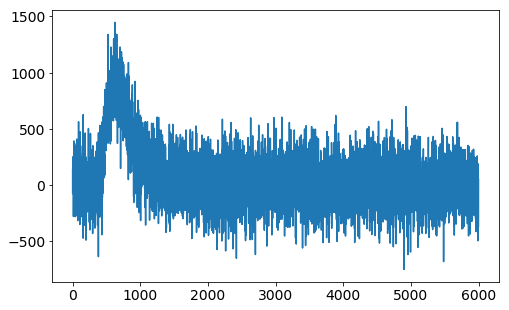

In [18]:
f = 328
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(traces_frequency[f].mean(axis = 0))
set_fontsize(ax, 14)

## Scan P2 F1

In [14]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [19]:
dset_idx = 1
dnames = [dset_names[dset_idx]]
devices = ('SynthHD Pro', )
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

In [29]:
data_devices['SynthHD Pro'][0]

(7.7896147, 1.33345e+10, 1.000075e+10, -12., -9.35, True, True)

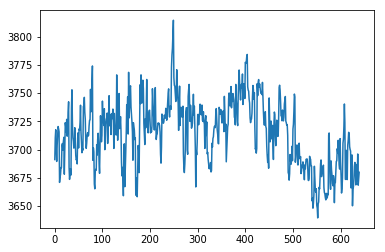

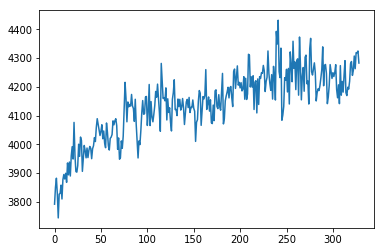

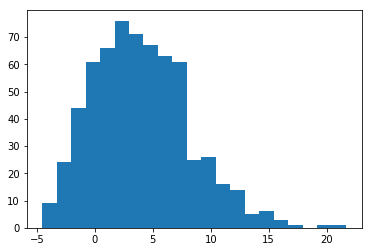

In [16]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [17]:
yag_cutoff = 250
ptn_cutoff = 3000
abs_cutoff = 4
fl_cutoff = -5000

In [52]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

54.7% data discarded


In [53]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

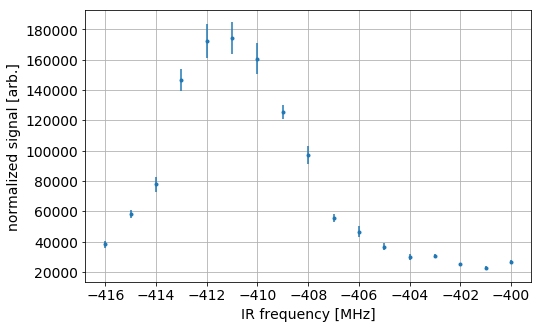

In [54]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

old_scan = [bin_means, stat, err]

In [55]:
scan_P2F1 = {}
scan_P2F1[dset_idx] = (bin_means, (stat, err))

## Scan P2 F1 RC with R0 F1 10 mW DET power

In [56]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [57]:
dset_idx = 2
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

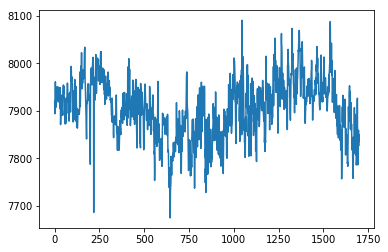

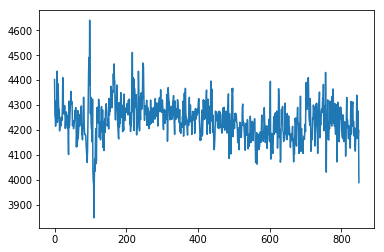

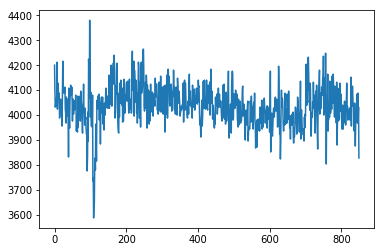

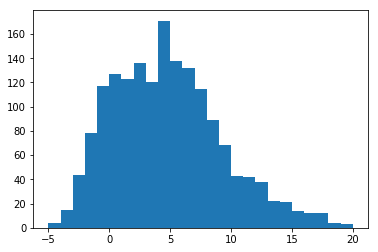

In [58]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [59]:
yag_cutoff = 250
ptn_cutoff = 7000
abs_cutoff = 4
fl_cutoff = -5000

In [60]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

45.8% data discarded


In [61]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

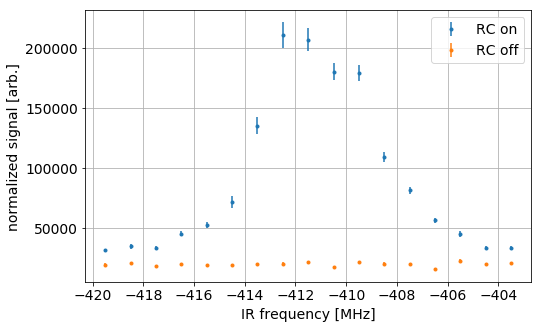

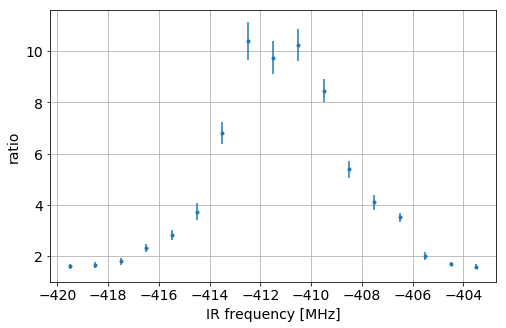

In [62]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [63]:
scan = {}
scan[dset_idx] = (bin_means, results)

In [64]:
ngroup = 10
nshots = 10
ntrace = 6000

scan_parameters_r = scan_parameters.reshape(-1,ngroup,nshots)
mask_sh_open_r = mask_sh_open.reshape(-1,ngroup,nshots)
mask_sh_closed_r = mask_sh_closed.reshape(-1,ngroup,nshots)

freq = -411.5
tmp = pmt_data_norm.reshape(-1,ngroup,nshots,ntrace).copy()
m = mask_sh_open_r[np.where(scan_parameters_r == freq)].reshape(-1,nshots)
tmp = tmp[np.where(scan_parameters_r == freq)].reshape(-1,nshots,ntrace)
o = tmp[m].reshape(-1,nshots//2,ntrace)
c = tmp[~m].reshape(-1,nshots//2,ntrace)
o = np.nanmean(o, axis = 1)
c = np.nanmean(c, axis = 1)

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


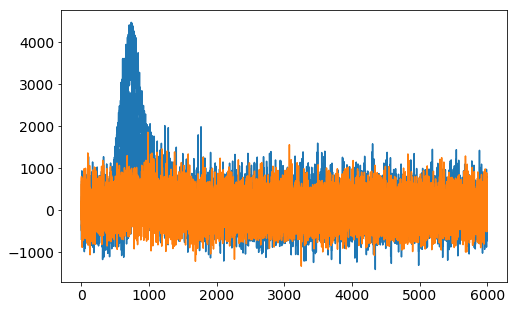

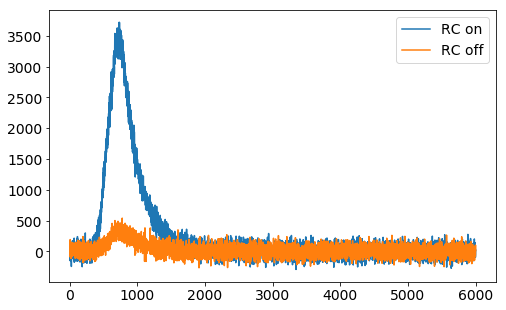

In [65]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(o[:5,:].T, color = 'C0', label = 'RC on')
ax.plot(c[:5,:].T, color = 'C1', label = 'RC off')

# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.nanmean(o, axis = 0), label = 'RC on')
ax.plot(np.nanmean(c, axis = 0), label = 'RC off')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

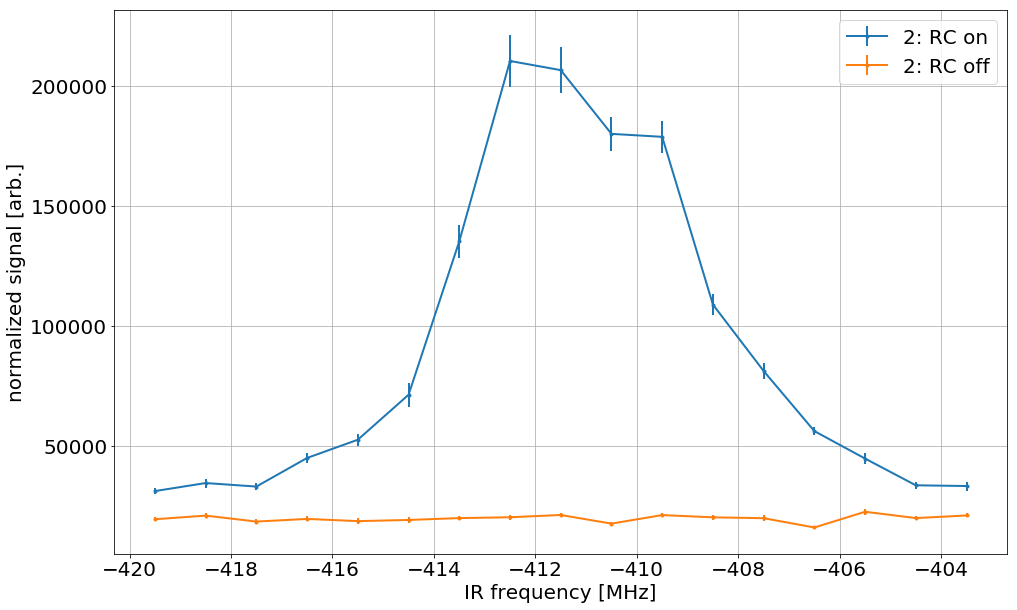

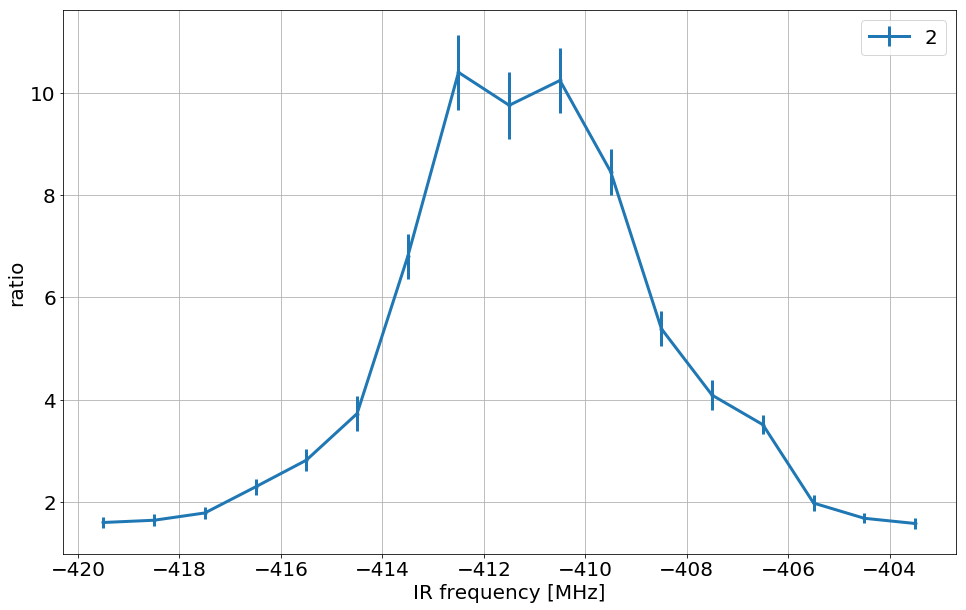

In [66]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm,r) in scan.items():
    ax.errorbar(bm, r[0][0], yerr = r[0][1], fmt = '.', label = f'{s}: RC on', lw = 2, ls = '-')
    ax.errorbar(bm, r[1][0], yerr = r[1][1], fmt = '.', label = f'{s}: RC off', lw = 2, ls = '-')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 20)

ax.grid(True)
set_fontsize(ax, 20)

fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)

set_fontsize(ax, 20)

## Scan P2 F1 RC with R0 F1 10 mW DET power

No RC phase modulation

In [67]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:1500]

In [68]:
dset_idx = 3
dnames = [dset_names[dset_idx],dset_names[7]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

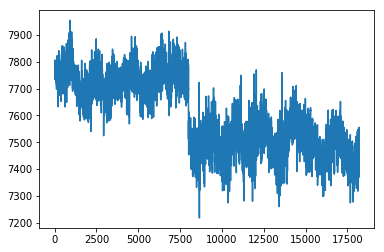

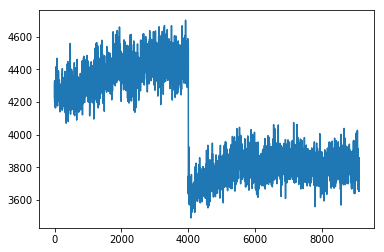

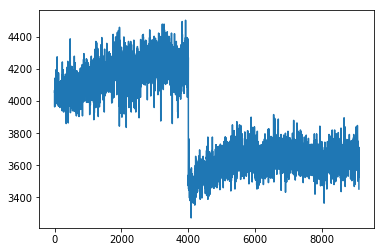

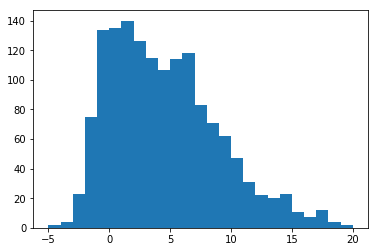

In [69]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [70]:
yag_cutoff = 250
ptn_cutoff = 7000
abs_cutoff = 6
fl_cutoff = -5000

In [71]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (mask_sh_open)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (mask_sh_closed)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")
print(f"{(mask & mask_sh_open).sum()/mask_sh_open.sum()*100:.1f}% data shutter open discarded")
print(f"{(mask & mask_sh_closed).sum()/mask_sh_closed.sum()*100:.1f}% data shutter closed discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

66.7% data discarded
66.6% data shutter open discarded
66.8% data shutter closed discarded


In [72]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

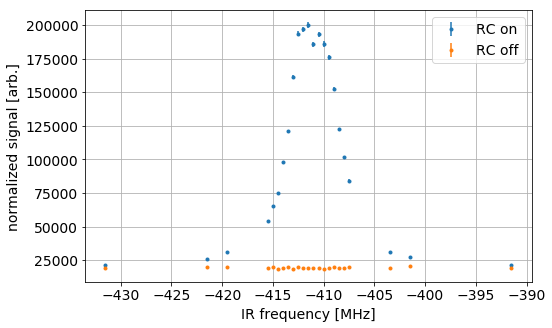

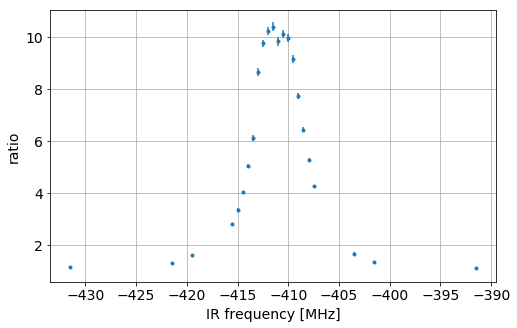

In [73]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [74]:
scan[dset_idx] = (bin_means, results)

In [75]:
ngroup = 10
nshots = 10
ntrace = 6000

scan_parameters_r = scan_parameters.reshape(-1,ngroup,nshots)
mask_sh_open_r = mask_sh_open.reshape(-1,ngroup,nshots)
mask_sh_closed_r = mask_sh_closed.reshape(-1,ngroup,nshots)

freq = -411.5
tmp = pmt_data_norm.reshape(-1,ngroup,nshots,ntrace).copy()
m = mask_sh_open_r[np.where(scan_parameters_r == freq)].reshape(-1,nshots)
tmp = tmp[np.where(scan_parameters_r == freq)].reshape(-1,nshots,ntrace)
o = tmp[m].reshape(-1,nshots//2,ntrace)
c = tmp[~m].reshape(-1,nshots//2,ntrace)
o = np.nanmean(o, axis = 1)
c = np.nanmean(c, axis = 1)

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


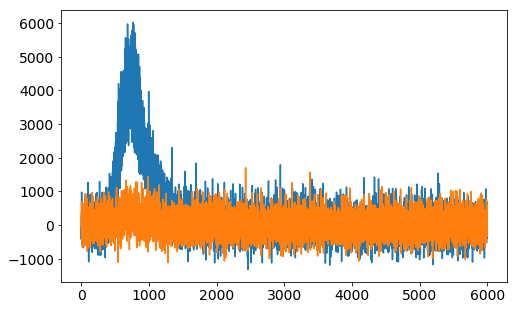

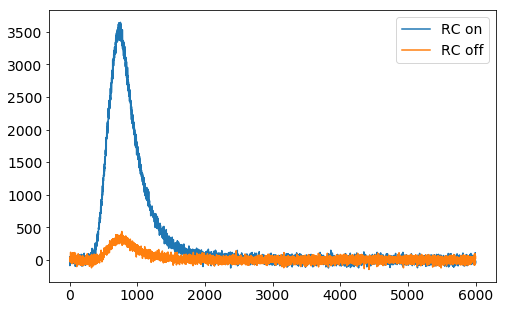

In [76]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(o[:5,:].T, color = 'C0', label = 'RC on')
ax.plot(c[:5,:].T, color = 'C1', label = 'RC off')

# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.nanmean(o, axis = 0), label = 'RC on')
ax.plot(np.nanmean(c, axis = 0), label = 'RC off')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

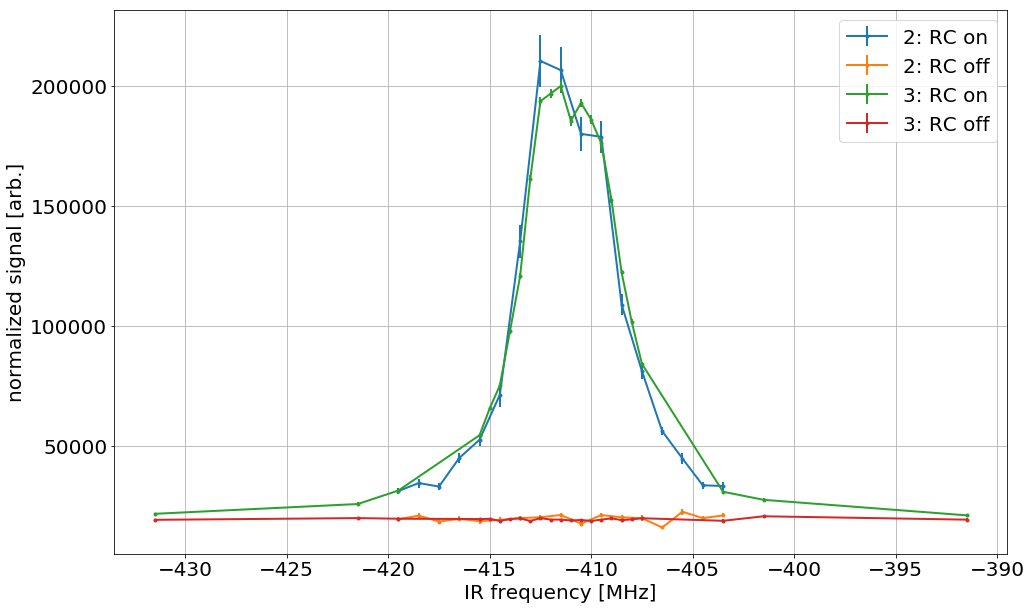

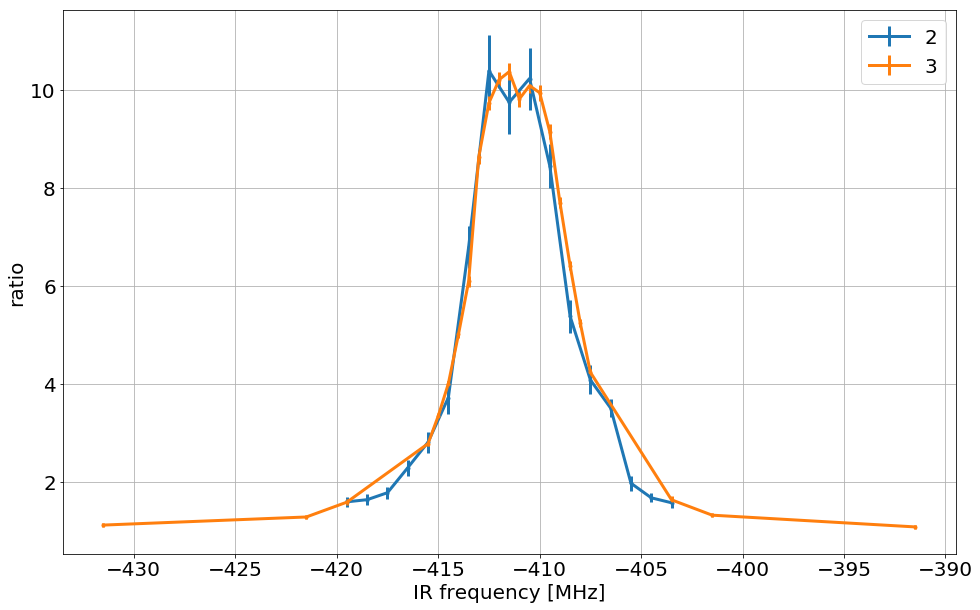

In [77]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm,r) in scan.items():
    ax.errorbar(bm, r[0][0], yerr = r[0][1], fmt = '.', label = f'{s}: RC on', lw = 2, ls = '-')
    ax.errorbar(bm, r[1][0], yerr = r[1][1], fmt = '.', label = f'{s}: RC off', lw = 2, ls = '-')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 20)

ax.grid(True)
set_fontsize(ax, 20)

fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)

# ax.axhline(1, lw = 3, color = 'k')

set_fontsize(ax, 20)

## Scan P2 F1 RC with R0 F1 10 mW DET power

With RC phase modulation on $\beta \approx 3.8$

In [78]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:1500]

In [79]:
dset_idx = 4
dnames = [dset_names[dset_idx], dset_names[dset_idx + 1], dset_names[8]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

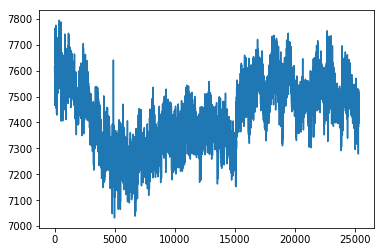

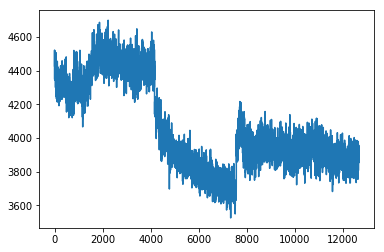

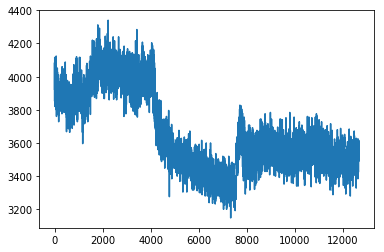

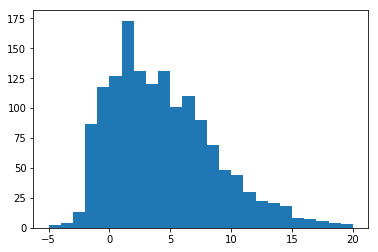

In [80]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [81]:
yag_cutoff = 250
ptn_cutoff = 7000
abs_cutoff = 6
fl_cutoff = -5000

In [82]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (mask_sh_open)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (mask_sh_closed)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")
print(f"{(mask & mask_sh_open).sum()/mask_sh_open.sum()*100:.1f}% data shutter open discarded")
print(f"{(mask & mask_sh_closed).sum()/mask_sh_closed.sum()*100:.1f}% data shutter closed discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

73.3% data discarded
68.7% data shutter open discarded
77.8% data shutter closed discarded


In [83]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

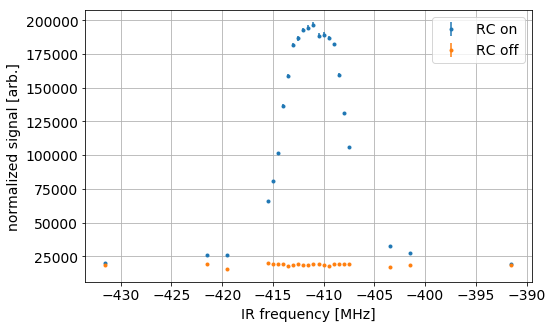

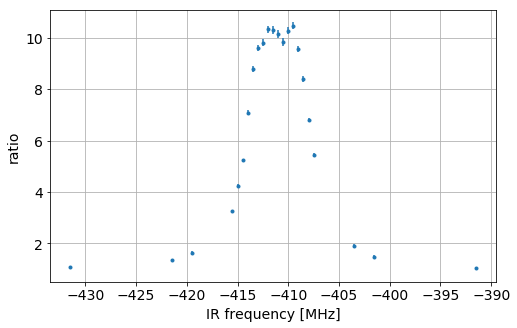

In [84]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [85]:
scan[dset_idx] = (bin_means, results)

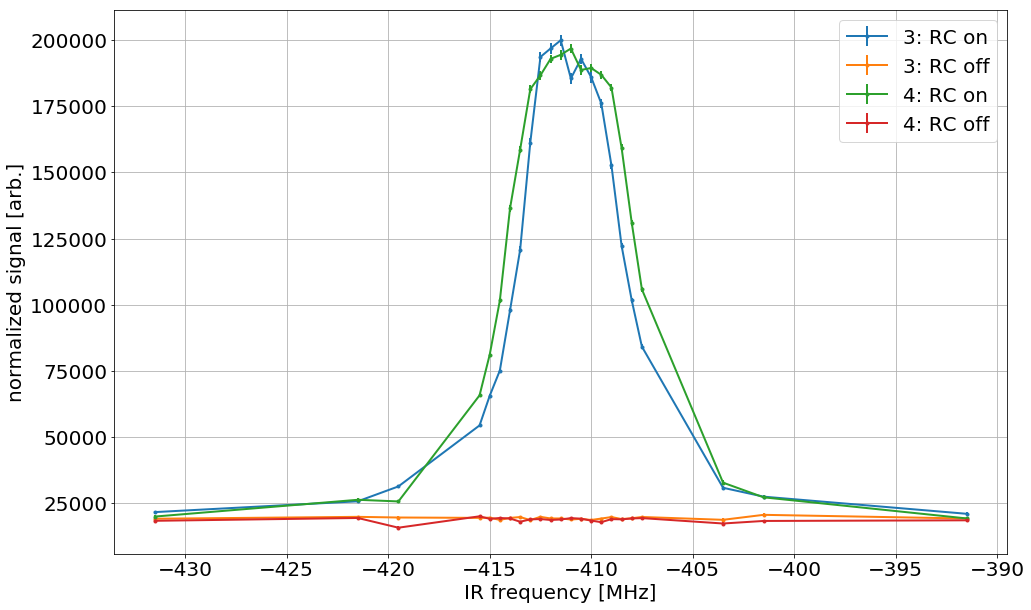

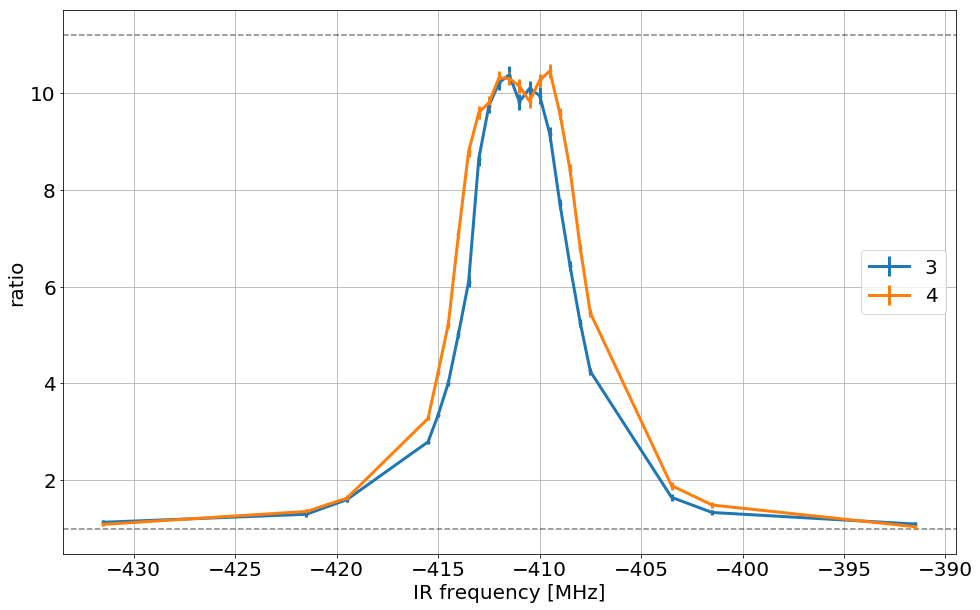

In [86]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm,r) in scan.items():
    if s in [3,4]:
        ax.errorbar(bm, r[0][0], yerr = r[0][1], fmt = '.', label = f'{s}: RC on', lw = 2, ls = '-')
        ax.errorbar(bm, r[1][0], yerr = r[1][1], fmt = '.', label = f'{s}: RC off', lw = 2, ls = '-')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 20)

ax.grid(True)
set_fontsize(ax, 20)

fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan.items():
    if s in [3,4]:
        ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
        ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)

ax.axhline(1, ls = '--', color = 'k', alpha = 0.5)
ax.axhline(11.2, ls = '--', color = 'k', alpha = 0.5)

set_fontsize(ax, 20)

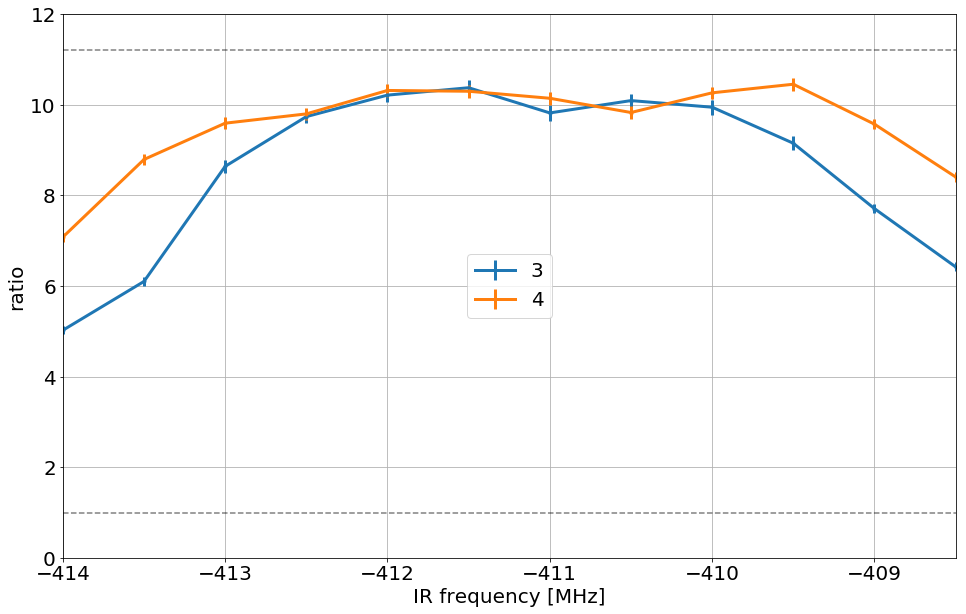

In [87]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan.items():
    if s in [3,4]:
        ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
        ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)
ax.axhline(1, ls = '--', color = 'k', alpha = 0.5)
ax.axhline(11.2, ls = '--', color = 'k', alpha = 0.5)

ax.set_xlim(-414,-408.5)
ax.set_ylim(0,12)
set_fontsize(ax, 20)

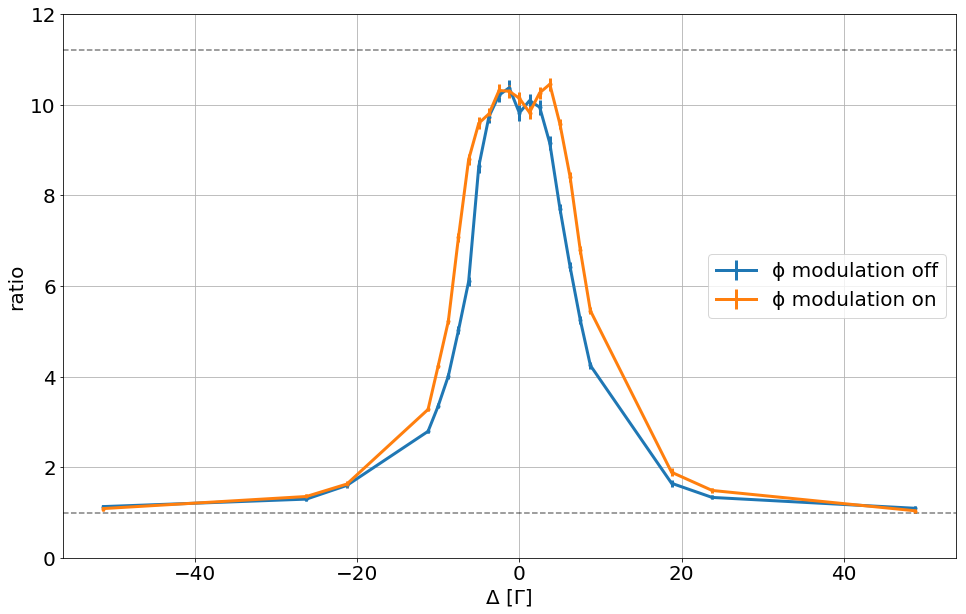

In [88]:
fig, ax = plt.subplots(figsize = (16,10))

labels = {3: 'ϕ modulation off', 4: 'ϕ modulation on'}
for s, (bm, r) in scan.items():
    if s in [3,4]:
        ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
        ax.errorbar((bm - (-411))*4/1.6, ratio, yerr = err, fmt = '.', label = f'{labels[s]}', ls = '-', lw = 3)

ax.set_xlabel('Δ [Γ]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)
ax.axhline(1, ls = '--', color = 'k', alpha = 0.5)
ax.axhline(11.2, ls = '--', color = 'k', alpha = 0.5)

# ax.set_xlim(-414,-408.5)
ax.set_ylim(0,12)
set_fontsize(ax, 20)

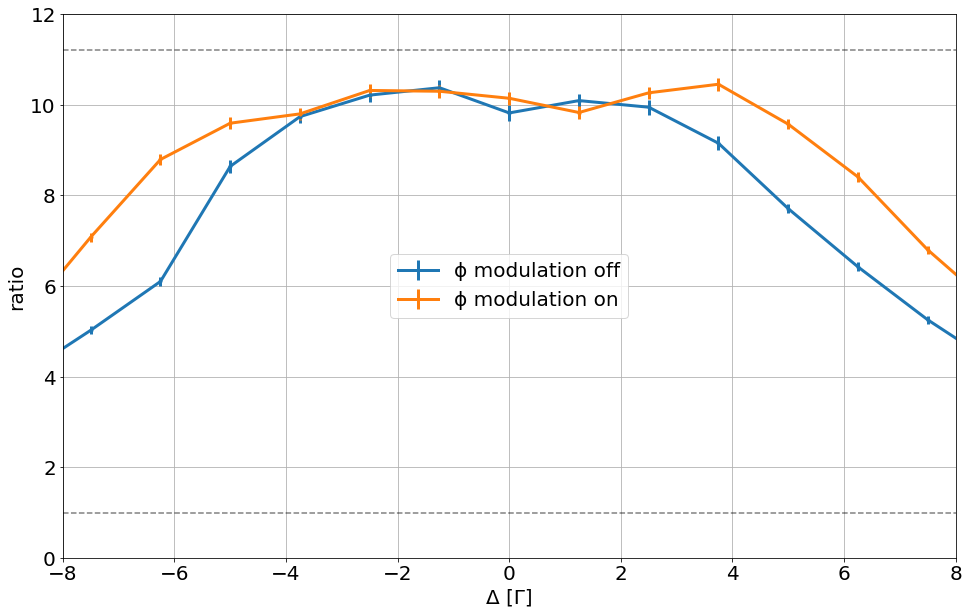

In [89]:
fig, ax = plt.subplots(figsize = (16,10))

labels = {3: 'ϕ modulation off', 4: 'ϕ modulation on'}
for s, (bm, r) in scan.items():
    if s in [3,4]:
        ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
        ax.errorbar((bm - (-411))*4/1.6, ratio, yerr = err, fmt = '.', label = f'{labels[s]}', ls = '-', lw = 3)

ax.set_xlabel('Δ [Γ]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)
ax.axhline(1, ls = '--', color = 'k', alpha = 0.5)
ax.axhline(11.2, ls = '--', color = 'k', alpha = 0.5)

ax.set_xlim(-8,+8)
ax.set_ylim(0,12)
set_fontsize(ax, 20)

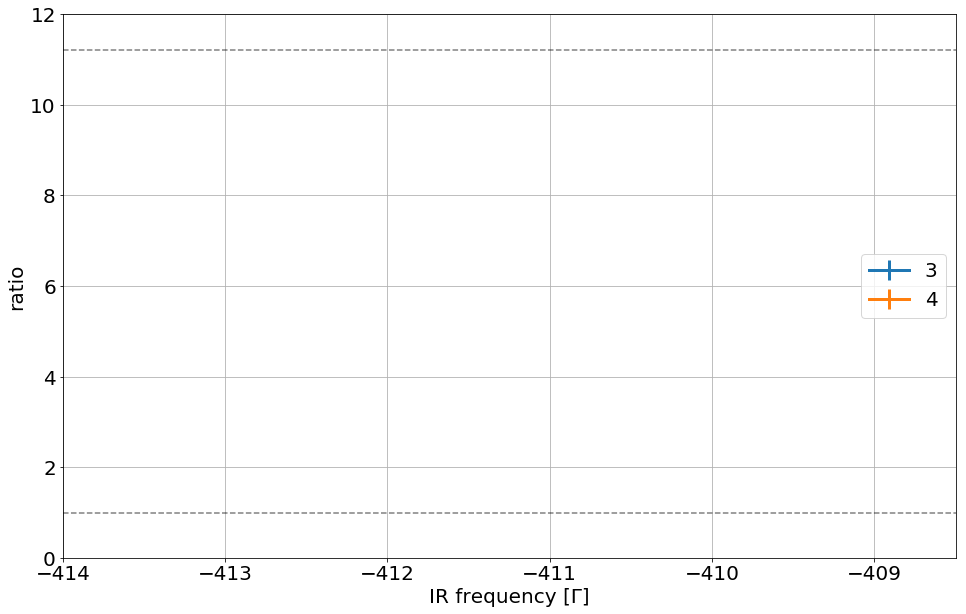

In [90]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan.items():
    if s in [3,4]:
        ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
        ax.errorbar(bm*4 / (1.6e6), ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [Γ]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)
ax.axhline(1, ls = '--', color = 'k', alpha = 0.5)
ax.axhline(11.2, ls = '--', color = 'k', alpha = 0.5)

ax.set_xlim(-414,-408.5)
ax.set_ylim(0,12)
set_fontsize(ax, 20)

In [91]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:1500]

In [92]:
dnames = [dset_names[10]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

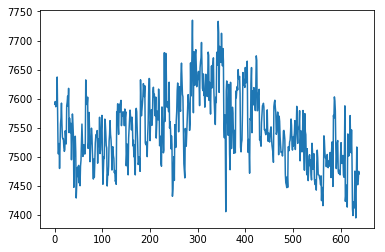

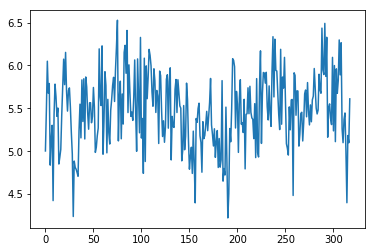

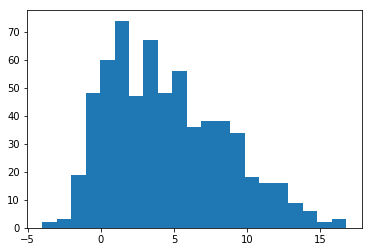

In [93]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), bins = 21);

In [94]:
yag_cutoff = 250
ptn_cutoff = 7000
abs_cutoff = 3
fl_cutoff = -5000

In [95]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

47.2% data discarded


In [96]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

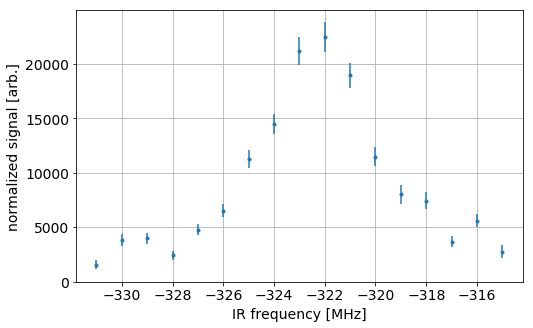

In [97]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan P2 F1 RC with R0 F2 10 mW DET power

With RC phase modulation on $\beta \approx 3.8$

In [110]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:1500]

In [111]:
dset_idx = 11
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

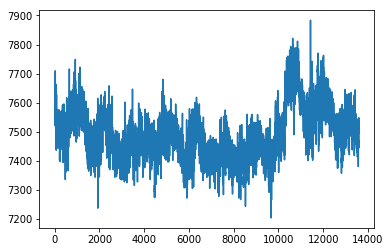

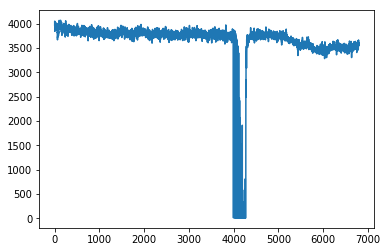

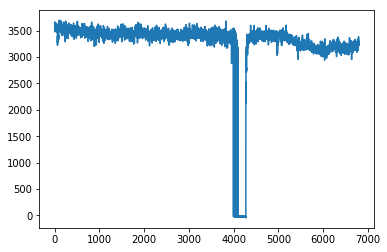

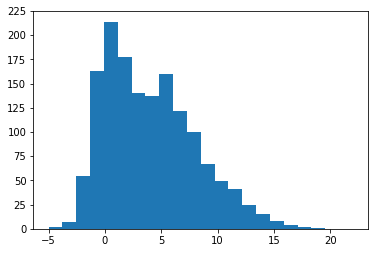

In [112]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,22,23));

In [113]:
yag_cutoff = 250
ptn_cutoff = 7000
abs_cutoff = 6
fl_cutoff = -5000

In [114]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (mask_sh_open)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (mask_sh_closed)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")
print(f"{(mask & mask_sh_open).sum()/mask_sh_open.sum()*100:.1f}% data shutter open discarded")
print(f"{(mask & mask_sh_closed).sum()/mask_sh_closed.sum()*100:.1f}% data shutter closed discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

70.1% data discarded
70.5% data shutter open discarded
69.7% data shutter closed discarded


In [115]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

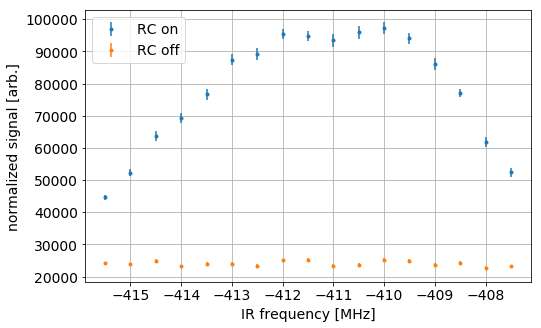

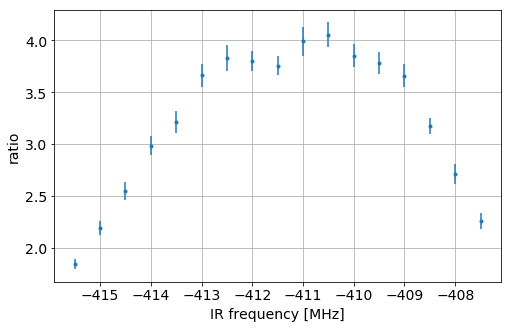

In [116]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [117]:
scan_R0F2 = {}
scan_R0F2[dset_idx] = (bin_means, results)

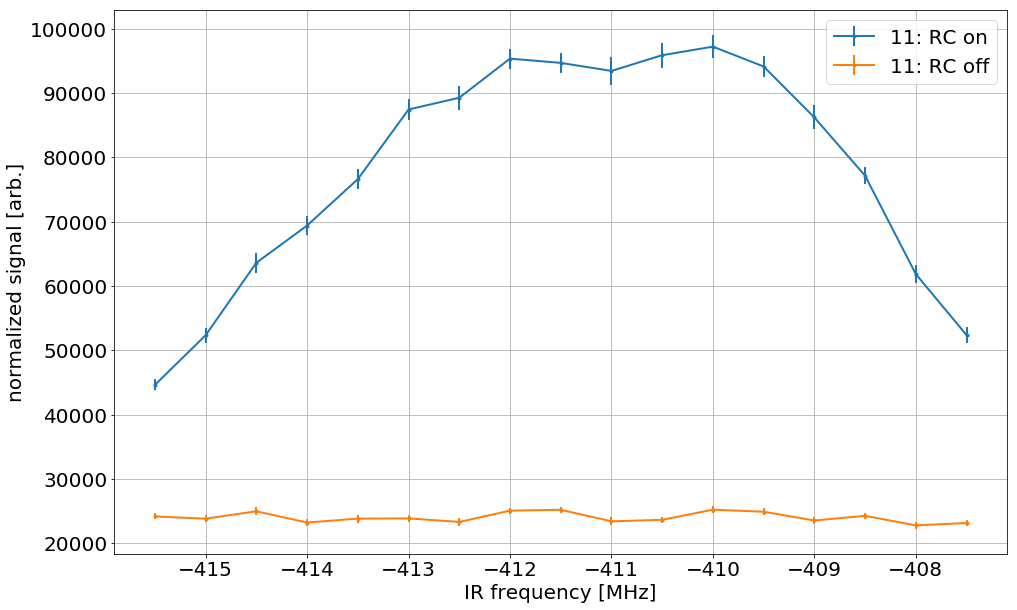

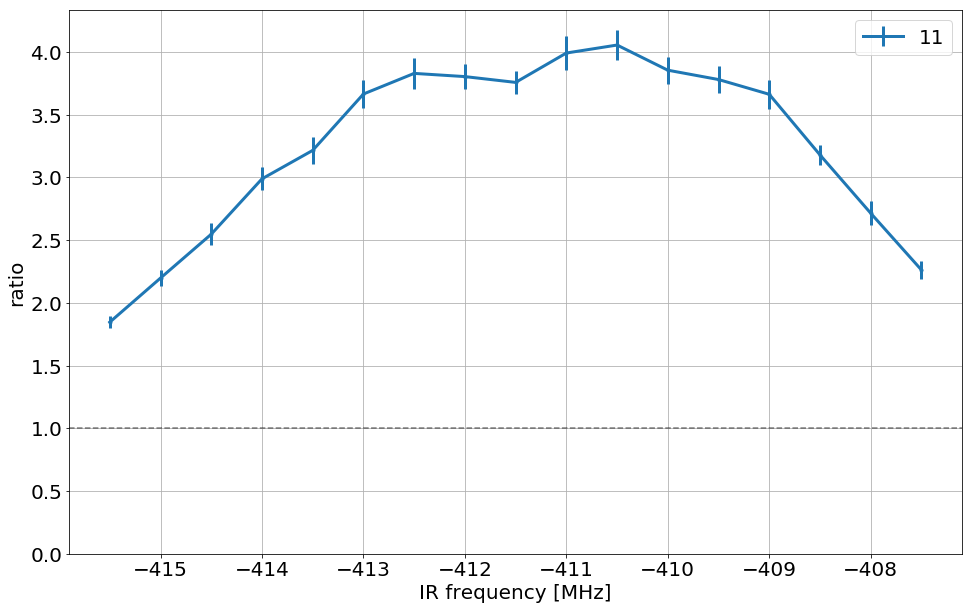

In [118]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm,r) in scan_R0F2.items():
    ax.errorbar(bm, r[0][0], yerr = r[0][1], fmt = '.', label = f'{s}: RC on', lw = 2, ls = '-')
    ax.errorbar(bm, r[1][0], yerr = r[1][1], fmt = '.', label = f'{s}: RC off', lw = 2, ls = '-')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 20)

ax.grid(True)
set_fontsize(ax, 20)

fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan_R0F2.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)

ax.axhline(1, ls = '--', color = 'k', alpha = 0.5)
# ax.axhline(11.2, ls = '--', color = 'k', alpha = 0.5)
ax.set_ylim(ymin = 0)

set_fontsize(ax, 20)

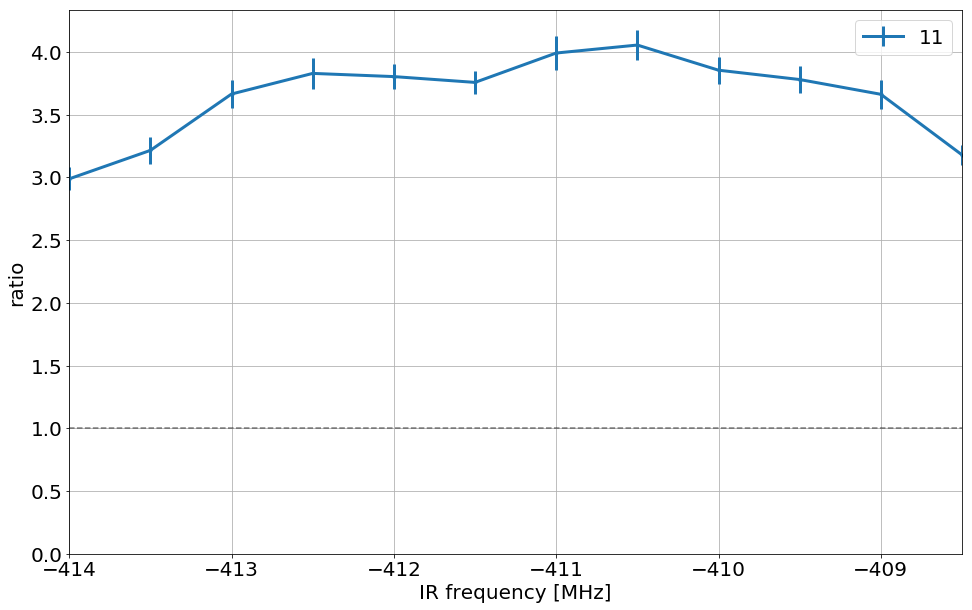

In [119]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan_R0F2.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)
ax.axhline(1, ls = '--', color = 'k', alpha = 0.5)
ax.set_xlim(-414,-408.5)
ax.set_ylim(ymin = 0)
set_fontsize(ax, 20)

## Scan P2 F1 RC with R0 F2 10 mW DET power

Without RC phase modulation on $\beta \approx 3.8$

In [120]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:1500]

In [121]:
dset_idx = 12
dnames = [dset_names[dset_idx]]
devices = ()
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
         
for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

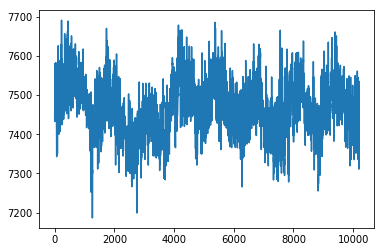

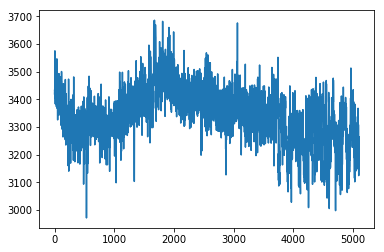

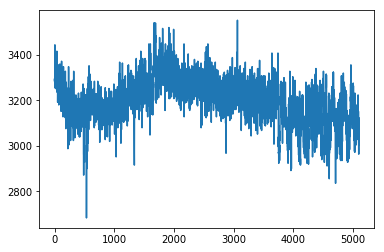

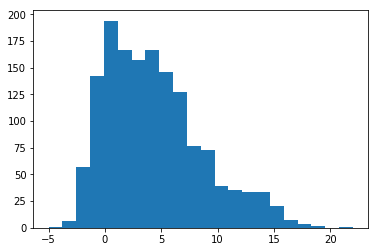

In [122]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,22,23));

In [123]:
yag_cutoff = 250
ptn_cutoff = 7000
abs_cutoff = 6
fl_cutoff = -5000

In [124]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (mask_sh_open)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (mask_sh_closed)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")
print(f"{(mask & mask_sh_open).sum()/mask_sh_open.sum()*100:.1f}% data shutter open discarded")
print(f"{(mask & mask_sh_closed).sum()/mask_sh_closed.sum()*100:.1f}% data shutter closed discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

71.5% data discarded
71.5% data shutter open discarded
71.5% data shutter closed discarded


In [125]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

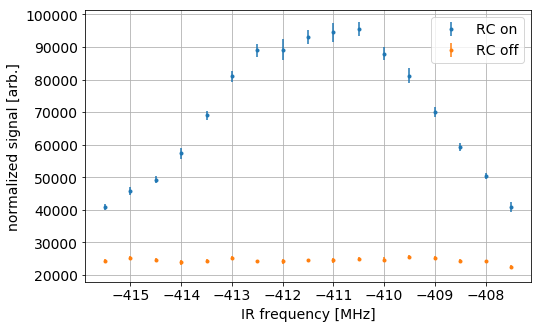

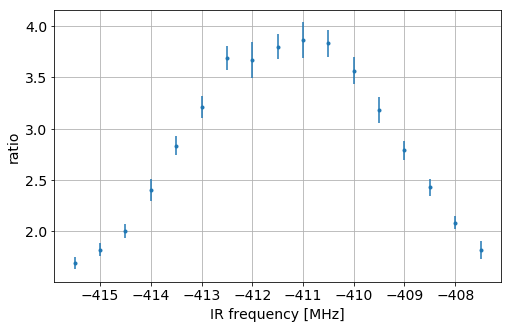

In [126]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [127]:
scan_R0F2[dset_idx] = (bin_means, results)

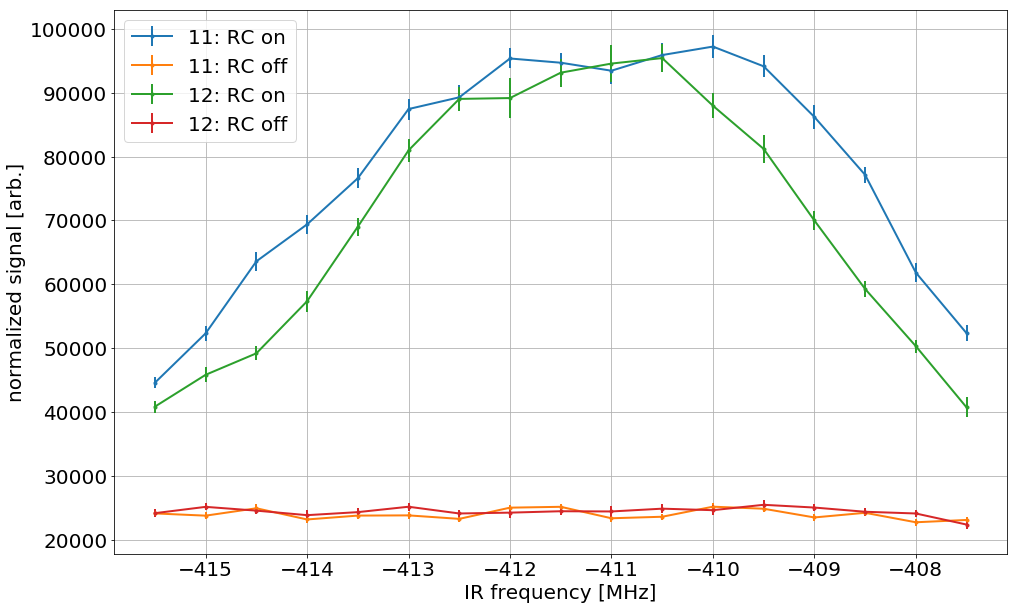

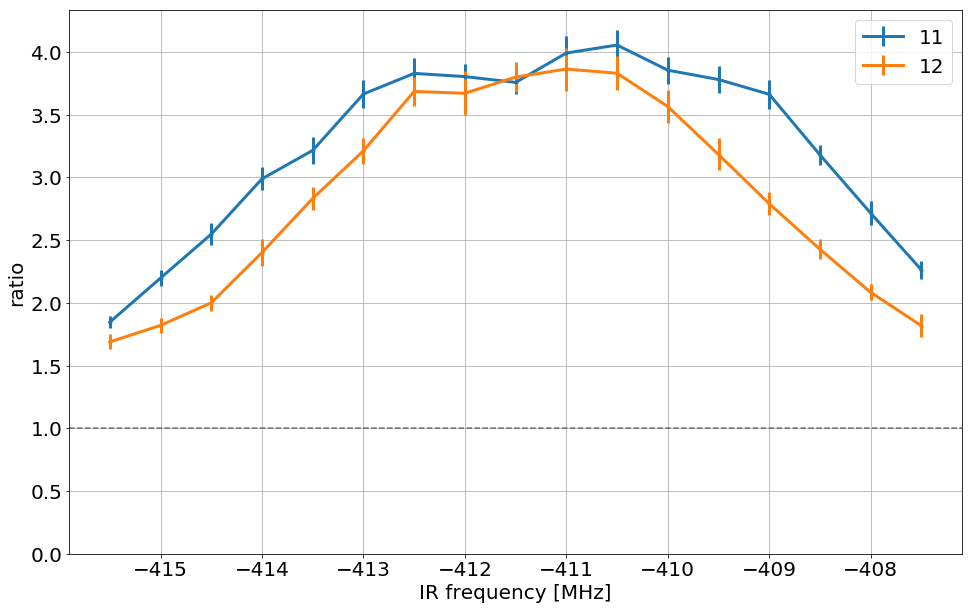

In [128]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm,r) in scan_R0F2.items():
    ax.errorbar(bm, r[0][0], yerr = r[0][1], fmt = '.', label = f'{s}: RC on', lw = 2, ls = '-')
    ax.errorbar(bm, r[1][0], yerr = r[1][1], fmt = '.', label = f'{s}: RC off', lw = 2, ls = '-')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 20)

ax.grid(True)
set_fontsize(ax, 20)

fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan_R0F2.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)

ax.axhline(1, ls = '--', color = 'k', alpha = 0.5)
# ax.axhline(11.2, ls = '--', color = 'k', alpha = 0.5)
ax.set_ylim(ymin = 0)

set_fontsize(ax, 20)

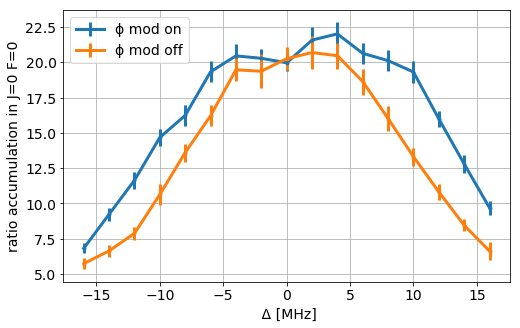

In [135]:
fig, ax = plt.subplots(figsize = (8,5))

labels = {11: "ϕ mod on", 12: "ϕ mod off"}
for s, (bm, r) in scan_R0F2.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm*4 - (-411.5*4), 3*(.337/.147)*(ratio-1)+1, yerr = 3*(.337/.147)*err, fmt = '.', label = labels[s], ls = '-', lw = 3)

ax.set_xlabel(' Δ [MHz]')
ax.set_ylabel('ratio accumulation in J=0 F=0')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

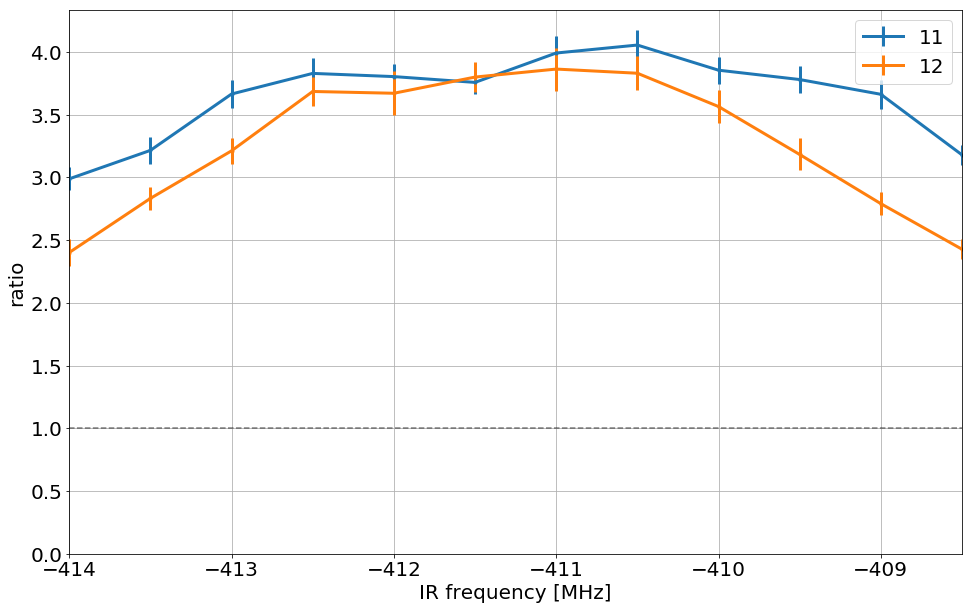

In [130]:
fig, ax = plt.subplots(figsize = (16,10))

for s, (bm, r) in scan_R0F2.items():
    ratio, err = ratio_with_error(r[0][0], r[1][0], r[0][1], r[1][1])
    ax.errorbar(bm, ratio, yerr = err, fmt = '.', label = f'{s}', ls = '-', lw = 3)

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')
ax.legend(fontsize = 20)

ax.grid(True)
ax.axhline(1, ls = '--', color = 'k', alpha = 0.5)
ax.set_xlim(-414,-408.5)
ax.set_ylim(ymin = 0)
set_fontsize(ax, 20)